In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore') # Ignore warning message

# date path
data_path = '../Data/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

Data Downcasting

In [2]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
        if df[col].dtype.name=="float64":
            df[col] = df[col].astype('float32')
            
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.5% compressed
54.2% compressed
39.8% compressed
70.8% compressed


## EDA and Data Preprocessing

### (0) Overview

In [3]:
comb_data = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
display(comb_data.head().T)
display(comb_data.describe().T)
display(comb_data.dtypes)

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.0,899.0,899.0,1709.050049,1099.0
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853210,1729.799683,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0
item_category_id,2935849.0,40.001383,17.100759,0.0,28.0,40.0,55.0,83.0


date                   object
date_block_num           int8
shop_id                  int8
item_id                 int16
item_price            float32
item_cnt_day            int16
item_name              object
item_category_id         int8
shop_name              object
item_category_name     object
dtype: object

### (1) Shops: create derived features ('city') and encode

Notes after checking, decide to do 4 things:
- Some shops have multiple id since they have franchise and non-franchise shops ---> decide to merge those id into one
- The first world of the shop name represents city ---> derive and encode 'city' column
- Only keep shop names shop ids that appeared in test set
- Drop 'shop name' column

In [4]:
shops.loc[:10, ['shop_name']]['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?'], dtype=object)

In [5]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [6]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

In [7]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [8]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [9]:
# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [10]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [11]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
# unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
# sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

In [12]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### (2) itmes: Create derived features

Notes after checking, decide to do 3 things:
- Some Category_name can be grouped into the same Category --> Extract the first world ---> Derive 'Category' column and encode
- Group all minority categories with subcategories less than 5 into "etc"
- Drop 'item_category_name' column

In [13]:
item_categories.loc[:10, ['item_category_name']]['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2'], dtype=object)

In [14]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  
item_categories['category'].value_counts()

category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [15]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [16]:
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [17]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

In [18]:
item_categories.head()

,item_category_id,category
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


### (3) itmes: Create derived features

Notes after checking, decide to do 4 things:
- Drop 'item_name' column
- Only keep items that appears in the test set
- Derive column 'first_sale_date'
- Derive column 'mean_price_across_shops'


In [19]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [20]:
# Leaking to imporve performance
unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

In [21]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [22]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
...,...,...,...
22160,22160,40,NaN
22161,22161,37,NaN
22165,22165,31,NaN
22168,22168,62,NaN


In [23]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

In [24]:
# Create column - mean_price_across_shops
mean_price_across_shops = sales_train.groupby('item_id').agg({'item_price': 'mean'})
items = items.join(mean_price_across_shops, how='left', on='item_id')
items.rename(columns={'item_price': 'mean_item_price_across_shops'}, inplace=True)
items.head()

,item_id,item_category_id,first_sale_date,mean_item_price_across_shops
0,0,40,34.0,NaN
1,1,76,34.0,NaN
2,2,40,34.0,NaN
3,3,40,34.0,NaN
4,4,40,34.0,NaN


### (4) sales_train

Notes after checking, decide to do 3 things:
- check the range of 'date'
- derive 'year' and 'month' columns for both sales_train and test data
- check 'item_price' and 'item_cnt_dat' range ---> remove outliers

Time period of the dataset

Notes:
- Checking the range of the date time period
- Derive 'month' and 'year' column
- Check the range of the 'item_cnt' and 'item_price' ---> remove outliers

In [25]:
print('Min date from train set: %s' % pd.to_datetime(sales_train['date'], format='%d.%m.%Y').min().date())
print('Max date from train set: %s' % pd.to_datetime(sales_train['date'], format='%d.%m.%Y').max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


In [26]:
# Extract time based features.
sales_train['year'] = sales_train['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_train['month'] = sales_train['date_block_num'].apply(lambda x: (x % 12))
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,02.01.2013,0,59,22154,999.0,1,2013,0
10,03.01.2013,0,25,2574,399.0,2,2013,0
11,05.01.2013,0,25,2574,399.0,1,2013,0
12,07.01.2013,0,25,2574,399.0,1,2013,0
13,08.01.2013,0,25,2574,399.0,2,2013,0


In [27]:
test['date_block_num'] = 34
test['year'] = test['date_block_num'].apply(lambda x: ((x//12) + 2013))
test['month'] = test['date_block_num'].apply(lambda x: (x % 12))
test.head()

,ID,shop_id,item_id,date_block_num,year,month
0,0,5,5037,34,2015,10
1,1,5,5320,34,2015,10
2,2,5,5233,34,2015,10
3,3,5,5232,34,2015,10
4,4,5,5268,34,2015,10


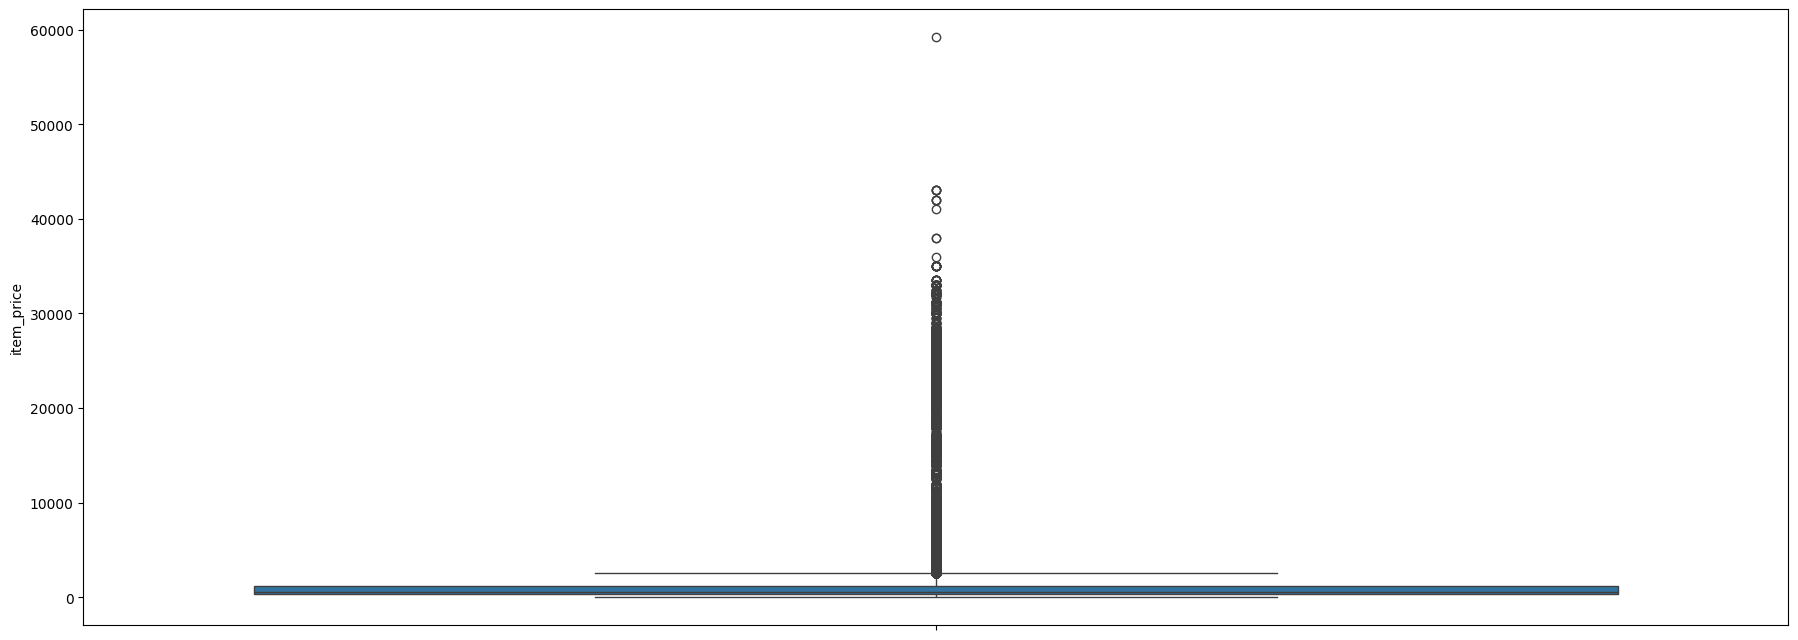

In [28]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sales_train['item_price'])
plt.show()

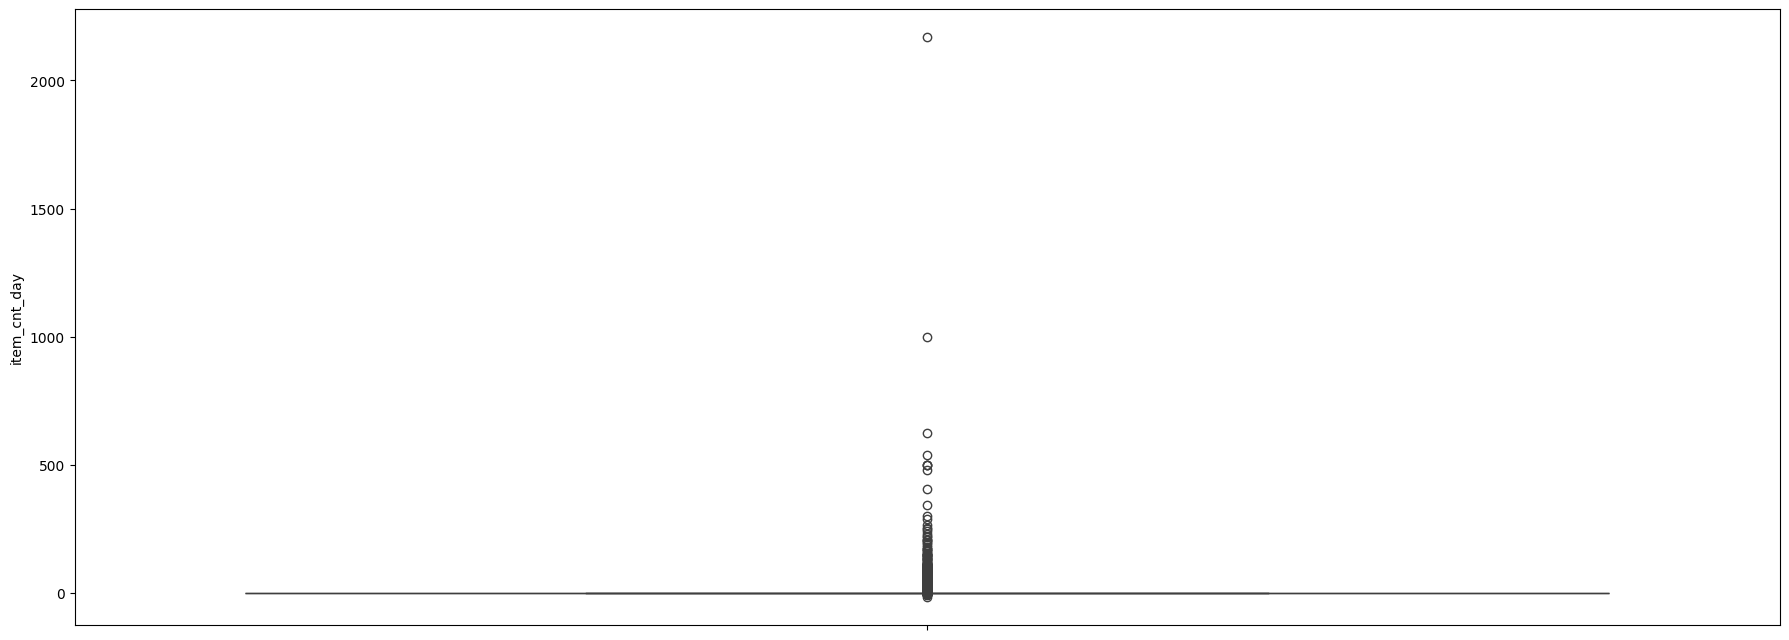

In [29]:
plt.subplots(figsize=(22, 8))
sns.boxplot(sales_train['item_cnt_day'])
plt.show()

In [30]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

### (5) Generate data combinations and derived features

Notes:
- Create a shell containing all combinations of 'date_block_num', 'shop_id', 'item_id'
- Derive aggragated variables base on the combined index
    a.'item_cnt_month'
    b.'item_price_mean'
    c.'item_count'
- Concatenate sales_train data + 'test'
- Merge the remaining data (shops, items, item_categories)

In [31]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)  # ertically stack arrays
train.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2574
2,0,59,2607
3,0,59,2614
4,0,59,2808


In [32]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2574,2.0,399.0
2,0,59,2607,NaN,NaN
3,0,59,2614,NaN,NaN
4,0,59,2808,15.0,999.0


In [33]:
import gc

# group variable garbage collection
del group
gc.collect()

2840

In [34]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group, sales_train
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2574,2.0,399.0,2.0
2,0,59,2607,NaN,NaN,NaN
3,0,59,2614,NaN,NaN,NaN
4,0,59,2808,15.0,999.0,9.0


In [37]:
# Concatenate test data, Merge remaining data

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)

# Replace NaN with 0
all_data = all_data.fillna(0)
all_data['year'] = all_data['year'].astype('int32')
all_data['month'] = all_data['month'].astype('int32')

display(all_data.head())
display(all_data.tail())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month
0,0,59,22154,1.0,999.0,1.0,0,0
1,0,59,2574,2.0,399.0,2.0,0,0
2,0,59,2607,0.0,0.0,0.0,0,0
3,0,59,2614,0.0,0.0,0.0,0,0
4,0,59,2808,15.0,999.0,9.0,0,0


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month
2952842,34,45,18454,0.0,0.0,0.0,2015,10
2952843,34,45,16188,0.0,0.0,0.0,2015,10
2952844,34,45,15757,0.0,0.0,0.0,2015,10
2952845,34,45,19648,0.0,0.0,0.0,2015,10
2952846,34,45,969,0.0,0.0,0.0,2015,10


In [38]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

68.1% compressed


In [40]:
display(all_data.head())
display(all_data.tail())

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month,city,item_category_id,first_sale_date,mean_item_price_across_shops,category
0,0,59,22154,1,999.0,1,0,0,30,37,0,676.921570,5
1,0,59,2574,2,399.0,2,0,0,30,55,0,404.716522,7
2,0,59,2607,0,0.0,0,0,0,30,55,0,295.933868,7
3,0,59,2614,0,0.0,0,0,0,30,55,0,298.463806,7
4,0,59,2808,15,999.0,9,0,0,30,30,0,1005.055908,3


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,year,month,city,item_category_id,first_sale_date,mean_item_price_across_shops,category
2952842,34,45,18454,0,0.0,0,2015,10,20,55,23,190.502411,7
2952843,34,45,16188,0,0.0,0,2015,10,20,64,32,1256.974976,8
2952844,34,45,15757,0,0.0,0,2015,10,20,55,0,202.016663,7
2952845,34,45,19648,0,0.0,0,2015,10,20,40,23,98.587502,5
2952846,34,45,969,0,0.0,0,2015,10,20,37,17,502.501404,5


In [41]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [42]:
resumetable(all_data)

Data Shape: (2952847, 13)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.00000,0.000000,0.000000
shop_id,int8,0,42,59.00000,59.000000,59.000000
item_id,int16,0,5100,22154.00000,2574.000000,2607.000000
item_cnt_month,int16,0,383,1.00000,2.000000,0.000000
item_price_mean,float32,0,23018,999.00000,399.000000,0.000000
item_count,int8,0,40,1.00000,2.000000,0.000000
year,int16,0,2,0.00000,0.000000,0.000000
month,int8,0,2,0.00000,0.000000,0.000000
city,int8,0,28,30.00000,30.000000,30.000000
item_category_id,int8,0,62,37.00000,55.000000,55.000000
